<a href="https://colab.research.google.com/github/ttya16/kaggle_LANL_Earthquake_Prediction/blob/master/kaggle_LANL_earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LANL-Earthquake-Prediction  
Referenced some ideas for feature engineering and dataset overview from [Kaggle kernels](https://www.kaggle.com/c/LANL-Earthquake-Prediction/kernels)


##概要
地震波データを150000ごとに区切って特徴量をいくつか計算し、GradientBoosting、XGBoost、RNN(GRU)のモデルで学習させてそれぞれの結果を比較した。

##データセットの準備
Colabにデータセットをダウンロードするフェーズ<br>
ローカルでやる場合は不要

In [1]:
#kaggleコンペのデータをダウンロードするための準備
!pip install kaggle
!pip install numpy==1.16.0 #numpy.quantileを使いたいため

In [2]:
#import data files from kaggle
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2542           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10183            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4040           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2555           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [4]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#Dowloadした訓練用ファイルを展開
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


##EDA
[これ](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)
とか参照

In [0]:
import numpy as np
import pandas as pd

In [6]:
%%time
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
print(train.shape)

(629145480, 2)
CPU times: user 2min 31s, sys: 39.1 s, total: 3min 10s
Wall time: 3min 21s


In [0]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

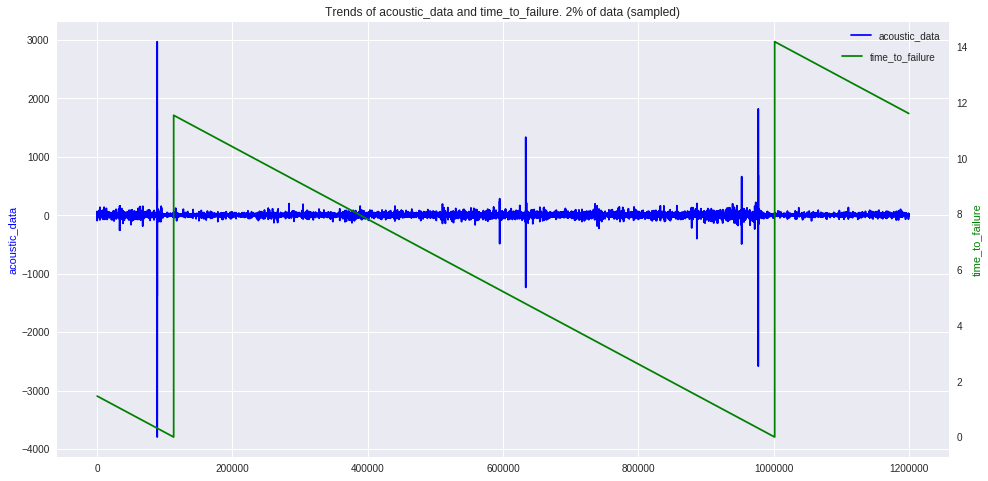

In [0]:
#visualize data
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

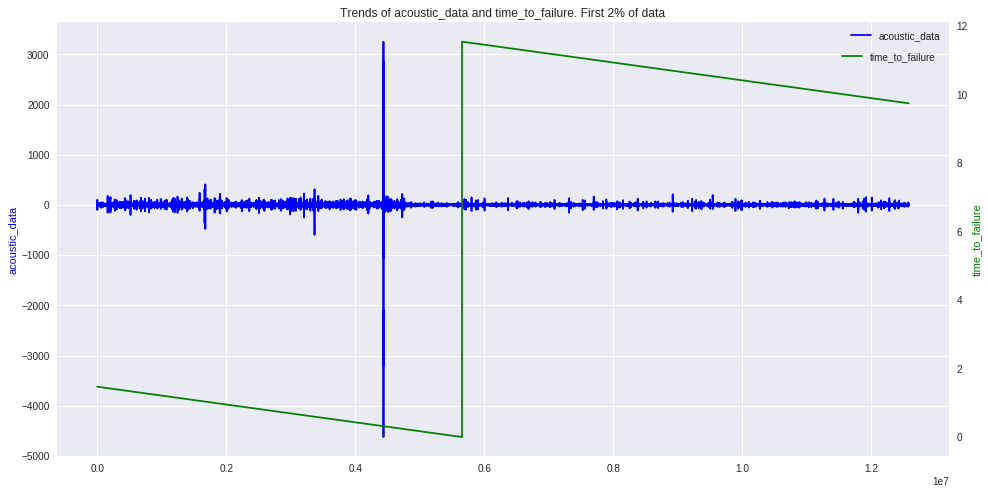

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

##Feature Engineering

In [0]:
#Add some statistical features to the dataset
#特徴量サンプリングとして基本的な統計量をいくつか追加してみる
#平均、標準偏差、最小値、最大値、尖度(kurtosis)、歪度(skewness)、差分 etc.
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.median())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X, 0.01))
    strain.append(np.quantile(X, 0.05))
    strain.append(np.quantile(X, 0.95))
    strain.append(np.quantile(X, 0.99))
    strain.append(np.mean(np.diff(X)))
    
    strain.append(np.mean(np.abs(X)))
    
    #rolling data of window size 100
    X_roll_std = X.rolling(100).std().dropna().values
    X_roll_mean = X.rolling(100).mean().dropna().values
    
    strain.append(X_roll_std.mean())
    strain.append(X_roll_std.std())
    strain.append(X_roll_std.min())
    strain.append(X_roll_std.max())
    strain.append(np.mean(np.diff(X_roll_std)))
    strain.append(np.mean(np.abs(X_roll_std)))
    strain.append(X_roll_mean.mean())
    strain.append(X_roll_mean.std())
    strain.append(X_roll_mean.min())
    strain.append(X_roll_mean.max())
    strain.append(np.mean(np.diff(X_roll_mean)))
    strain.append(np.mean(np.abs(X_roll_mean)))

    
    return pd.Series(strain)


### 学習データ準備
メモリ対策でchunksize指定で読み込んでいく。
特徴量の計算はテストデータのサイズに合わせて150000ごとに計算する。

In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv", iterator=True, chunksize=150000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()

for chunk in train:
  df = df.append(chunk)
  if len(df) >= 150000:
    df = df[-150000:]
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    

In [122]:
#標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
print(X_train_sc.shape)
X_train_sc[0]

(4195, 25)


array([ 1.4243304 , -0.17014507,  0.19316411, -0.2181291 ,  0.94727584,
       -0.49115666, -0.31361706,  0.22863044,  0.07886163, -0.09827707,
       -0.16325772, -1.32660275,  0.01925324, -0.13720181, -0.19116596,
       -0.14624396, -0.18592029, -0.12561152, -0.13720181,  1.42333798,
       -0.09856467,  0.24138958, -0.15348856, -0.48724291,  1.28588598])

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_sc, y_train, test_size=0.1,shuffle=False)

In [124]:
print(X_tr.shape)
print(X_val.shape)

(3775, 25)
(420, 25)


In [125]:
y_train.shape

(4195,)

## Create Model & Train

### GradientBoosting

In [0]:
#勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gbrt = GradientBoostingRegressor(max_depth = 2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 300):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_tr, y_tr)
  y_pred = gbrt.predict(X_val)
  val_error = mean_absolute_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    
  if error_going_up > 10:
    break


In [126]:
#早期打ち切りなしでやりたい場合
gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=120)
gbrt.fit(X_tr, y_tr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### XGBoost

In [127]:
#XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=3, n_estimators = 200)

xgb_model.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### RNN

In [131]:
#RNN model
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNGRU, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, 25)))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_8 (CuDNNGRU)       (None, 48)                10800     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                490       
_________________________________________________________________
batch_normalization_7 (Batch (None, 10)                40        
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 11,341
Trainable params: 11,321
Non-trainable params: 20
_________________________________________________________________


In [0]:
X_tr_reshaped = np.reshape(np.array(X_tr), (X_tr.shape[0], 1, X_tr.shape[1]))

In [133]:
from keras.optimizers import adam
model.compile(optimizer = adam(lr=0.005), loss='MAE')
model.fit(X_tr_reshaped, y_tr, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
3775/3775 [==============================] - 2s 557us/step - loss: 4.0911
Epoch 2/20
3775/3775 [==============================] - 1s 232us/step - loss: 2.4859
Epoch 3/20
3775/3775 [==============================] - 1s 226us/step - loss: 2.3742
Epoch 4/20
3775/3775 [==============================] - 1s 232us/step - loss: 2.3188
Epoch 5/20
3775/3775 [==============================] - 1s 231us/step - loss: 2.2799
Epoch 6/20
3775/3775 [==============================] - 1s 233us/step - loss: 2.3032
Epoch 7/20
3775/3775 [==============================] - 1s 229us/step - loss: 2.2894
Epoch 8/20
3775/3775 [==============================] - 1s 227us/step - loss: 2.2730
Epoch 9/20
3775/3775 [==============================] - 1s 229us/step - loss: 2.2517
Epoch 10/20
3775/3775 [==============================] - 1s 227us/step - loss: 2.2258
Epoch 11/20
3775/3775 [==============================] - 1s 232us/step - loss: 2.2435
Epoch 12/20
3775/3775 [==============================] - 1s 238

### Plot results

(420,)
GradientBoosting 2.171655870117684
XGBoosting 2.274359107340223
GRU 2.174145395587555
Blend 1.9575856787686194


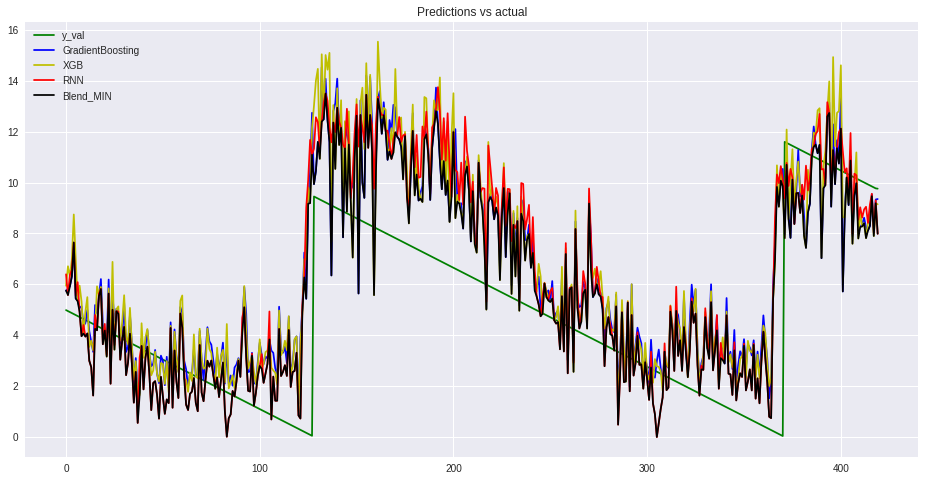

In [148]:
X_val_reshaped = np.reshape(np.array(X_val), (X_val.shape[0], 1, X_val.shape[1]))

y_pred_rnn = model.predict(X_val_reshaped)
y_pred_gbrt = gbrt.predict(X_val)
y_pred_xgb = xgb_model.predict(X_val)
y_pred_blend_min = np.minimum(np.minimum(np.reshape(y_pred_rnn, (y_pred_rnn.shape[0],)), y_pred_gbrt), y_pred_xgb)
print(y_pred_blend.shape)
val_error_gbrt = mean_absolute_error(y_val, y_pred_gbrt)
val_error_xgb = mean_absolute_error(y_val, y_pred_xgb)
val_error_rnn = mean_absolute_error(y_val, y_pred_rnn)
val_error_blend_min = mean_absolute_error(y_val, y_pred_blend_min)
print("GradientBoosting",val_error_gbrt)
print("XGBoosting", val_error_xgb)
print("GRU", val_error_rnn)
print("Blend", val_error_blend)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(np.array(y_val), color='g', label='y_val')
plt.plot(y_pred_gbrt, color='b', label='GradientBoosting')
plt.plot(y_pred_xgb, color='y', label='XGB')
plt.plot(y_pred_rnn, color='r', label='RNN')
plt.plot(y_pred_blend_min, color='k', label='Blend_MIN')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### 考察

・全体的に予測値は真の値よりも大きい傾向がある？<br>→各モデルの予測値のうち最小のものを選択した結果Blend_MIXの誤差が最小になった。<br>
・Validation Scoreはどのモデルも似たり寄ったりでそんなに良くないが、特徴量次第では変わってくるかもしれない。

## テストデータをfitさせる

In [0]:
#テストデータを展開
!unzip test.zip

In [150]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test = sc.fit_transform(X_test)
print(X_test.shape)

(2624, 25)


In [0]:
X_test_reshaped = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))

pred_rnn = model.predict(X_test_reshaped)
pred_gbrt = gbrt.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_blend_min = np.minimum(np.minimum(np.reshape(pred_rnn, (pred_rnn.shape[0],)), pred_gbrt), pred_xgb)

In [0]:
submission['time_to_failure'] = pred_blend_min
submission.to_csv('submission.csv')

In [153]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Message"

100% 74.9k/74.9k [00:09<00:00, 7.72kB/s]
Successfully submitted to LANL Earthquake Prediction

↑Blend_MINの結果を提出してスコア1.744だった。
テストデータに偶然良くハマった可能性がある。

## Further Improvements
* 特徴量の改善？
* 学習データの整形ももっといい方法があるか？
* 別のモデル？(CatBoost, BiDirectionalRNN)